In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.integrate import quad
import warnings
warnings.filterwarnings("ignore")

plt.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
plt.rc('text', usetex=True)

In [2]:
GeV = 1
MeV = 1e-3
keV = 1e-6

hbarc = 0.19732698 # GeV fm
Centimeter = 1/hbarc * 10**13
c = 2.997925e8
Second = c*1e2*Centimeter
Kilogram = c**2 / (1.602e-19 )*GeV/1e9
kpc = 3.086e21 * Centimeter
KilogramDay = Kilogram * 24*3600*Second
tonneYr = 365250 * KilogramDay
mp = 0.93827208816
Deff = 0.997 * kpc
rho_X = 0.3 * GeV * Centimeter**(-3)
unitsCM2S = Centimeter**2 * Second
amu = mp/1.00727647
mn = 0.93956542052
Me = 510.998950 * keV

# Cosmic ray

In [3]:
# Rigidity [GV], Modulated Spectrum [(m^2 s sr GV)^{-1}], LIS
proton_data = np.genfromtxt('data/TABLE_Protons_R.txt')
he4_data = np.genfromtxt('data/TABLE_Helium_R.txt')

def dIdR(r, spec):
    """
    Interpolate the data
    specs: 'proton' or 'helium'
    r: rigidity
    """
    if spec == 'proton':
        raw = proton_data
    elif spec == 'he4':
        raw = he4_data
    else:
        raise ValueError('spec must be proton or helium')

    f = interp1d(raw[:, 0], raw[:, 1], fill_value='extrapolate')
    return f(r)

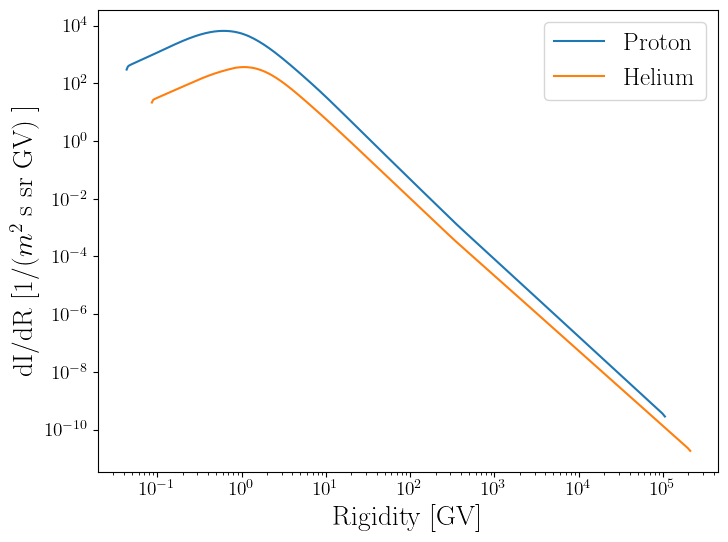

In [4]:
plt.figure(figsize=(8, 6))
plt.plot(proton_data[:,0], proton_data[:,1], label='Proton')
plt.plot(he4_data[:,0], he4_data[:,1], label='Helium')

plt.legend(fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Rigidity [GV]', fontsize=20)
plt.ylabel('dI/dR [1/($m^2$ s sr GV) ]', fontsize=20)
plt.show()


In [5]:
rays = {
    "mi" : {'proton': mp, 'he4':4.002602*amu},
    "Zei": {'proton': 1, 'he4':2},
    "Ai" : {'proton': 1, 'he4':4},
    "ji" : {'proton': 0.5, 'he4': 0}
}

def T2R(T, spec):
    """
    Convert rigidity to kinetic energy
    T: kinetic energy
    spec: proton or helium
    """
    return np.sqrt(T**2 + 2*T*rays['mi'][spec]) / rays['Zei'][spec]

def R2T(R, spec):
    """
    Convert kinetic energy to rigidity
    R: rigidity
    spec: proton or helium
    """
    return np.sqrt(rays['mi'][spec]**2 + (R * rays['Zei'][spec])**2) - rays['mi'][spec]

TdatMin = (R2T(proton_data[0,0], 'proton'), R2T(he4_data[0,0], 'he4'))
TdatMax = (R2T(proton_data[-1,0], 'proton'), R2T(he4_data[-1,0], 'he4'))
print(TdatMin)
print(TdatMax)

(0.0009999705749156318, 0.003996675226585644)
(105099.06173210002, 420396.2716163882)


In [6]:
def dRdT(t, spec):
    """
    flux of cosmic rays
    t: kinetic energy
    spec: proton or helium
    """
    Zei = rays["Zei"][spec]
    mi = rays["mi"][spec]
    return (2*mi + 2*t) / np.sqrt(2*mi*t + t**2) / (2*Zei)

def dPhidT(t, spec):
    """
    flux of cosmic rays
    t: kinetic energy
    spec: proton or helium
    """
    res = 4*np.pi/100**2 / (Centimeter**2 * Second * GeV)
    res *= dIdR(T2R(t, spec), spec) * dRdT(t, spec)
    return res

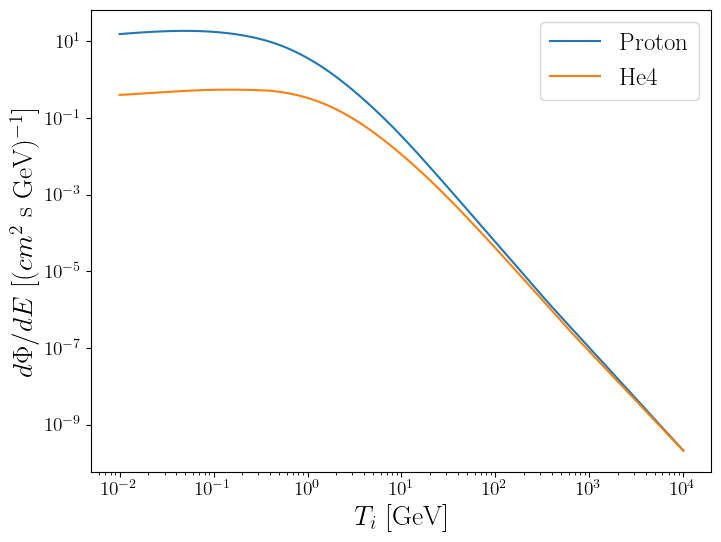

In [7]:
plt.figure(figsize=(8, 6))
tt = np.logspace(-2, 4, 100)
plt.plot(tt, Centimeter**2*Second*GeV*dPhidT(tt, 'proton'), label='Proton')
plt.plot(tt, Centimeter**2*Second*GeV*dPhidT(tt, 'he4'), label='He4')

plt.legend(fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$T_i$ [GeV]', fontsize=20)
plt.ylabel('$d\Phi/dE$ [($cm^2$ s GeV)$^{-1}$]', fontsize=20)
plt.show()

## CR-DM cross section

In [8]:
def Fhelm(q, A):
    """
    Helm form factor
    q: momentum transfer [GeV]
    A: mass number of the nucleus
    """
    s = 0.9
    r = np.sqrt((1.23*A**(1/3)-.6)**2 + 7/3*np.pi**2*0.52**2 - 5*0.9**2)
    qr = q*r/hbarc
    qs = q*s/hbarc
    
    if 0 < q < 4:
        return 3 * (np.sin(qr)-qr*np.cos(qr)) / qr**3 * np.exp(-qs**2/2)
    elif q > 4:
        return 0
    else:
        return 1

def gi(q2, l):
    """
    Dipole form factor
    q2: momentum transfer squared [GeV^2]
    l: Lambda, charge radius of proton and neutron: 0.770 & 0.410
    """
    return (1+q2/l**2)**(-2)


def nuclear_res(q, A, Ji):
    """
    Nuclear response function FM
    q: momentum transfer [GeV]
    A: mass number of the nucleus
    Ji: spin of the nucleus
    """
    if A == 1:
        res = 0.0397887 * gi(q**2, 0.77)**2
    elif A == 4:
        res = 0.31831 * gi(q**2, 0.41)**2
    else:
        res = A**2 * Fhelm(q, A)**2 /(16*np.pi)
    return 4*np.pi * 4 * res /(2*Ji+1)


In [9]:
def reduced_mass(m1, m2):
    """
    reduced mass
    m1, m2: masses
    """
    return m1*m2 / (m1+m2)

def xsec_XP(g, mchi, mphi, kk=0):
    """
    NR cross section
    g: coupling
    mchi: DM mass
    mphi: mediator mass
    """
    return 4 * g**4 * reduced_mass(mchi, mp)**2 / (np.pi * mphi**4 * (1+4*kk**2/mphi**2)) / Centimeter**2 / GeV**2

## Kinematics

In [10]:
def TxMin(Ti, mi, mx, de):
    """
    Minimum kinetic energy of the DM
    Ti: kinetic energy of the cosmic ray
    mi: mass of the cosmic ray
    mx: mass of the DM
    de: mass spliting
    """
    if de == 0:
        return 0
    d1 = 2*(mi+mx)**2 + 4*mx*Ti
    n1 = 2*mx*Ti*(2*mi+Ti) - 2*(mi*(mi+mx)+mx*Ti)*de + (mi+mx+Ti)*de**2
    n2 = -Ti*(2*mi+Ti) * (-2*mx*Ti+2*(mi+mx)*de+de**2) * (2*mx*(Ti-de)-de**2 + 2*mi*(2*mx+de))
    return (n1 - np.sqrt(n2)) / d1


def TxMax(Ti, mi, mx, de):
    if de == 0:
        return 0
    d1 = 2*(mi+mx)**2 + 4*mx*Ti
    n1 = 2*mx*Ti*(2*mi+Ti) - 2*(mi*(mi+mx)+mx*Ti)*de + (mi+mx+Ti)*de**2
    n2 = -Ti*(2*mi+Ti) * (-2*mx*Ti+2*(mi+mx)*de+de**2) * (2*mx*(Ti-de)-de**2 + 2*mi*(2*mx+de))
    return (n1 + np.sqrt(n2)) / d1

def TxMinGlobal(mx, de):
    return de**2 / (2*mx)

def deMax(Tx, mx):
    # delta Max
    return np.sqrt(2*mx*Tx)

def TiMin(Tx, mii, mx, de):
    if de > deMax(Tx, mx):
        return np.inf
    sqroot = Tx * (2*mx+Tx+2*de) * (2*mx*Tx-de**2) * (4*mii**2 + 2*mx*Tx - de**2)
    return (-2*mii + Tx + de + np.sqrt(sqroot) / (2*mx*Tx-de**2)) / 2

## Full differential cross section

In [11]:
def dsigmadTxVector(Tx, Ti, mx, de, gxi, mA, iS):
    """
    Differential cross sections of DM-cosmic ray nucleus (vector case)
    Tx: DM kinetic energy
    Ti: incoming CR kinetic energy
    mx: DM mass
    de: mass splitting
    gxi: x/nucleon to mediator coupling (assume they are the same)
    mA: mediator mass
    iS: species of CR 'proton' or 'he4'
    return: [GeV^-3]
    """
    mi = rays['mi'][iS]
    n1 = gxi**4 * (4*mx*(mi+Ti)**2 -2*((mi+mx)**2+2*mx*Ti)*Tx + 2*mx*Tx**2 - 4*mx*(mi+Ti)*de + (mx-Tx)*de**2)
    d1 = 2*np.pi*Ti * (2*mi+Ti) * (mA**2+2*mx*Tx-de**2)**2 / GeV**3
    fm = nuclear_res(np.sqrt(2*mx*Tx-de**2), rays['Ai'][iS], rays['ji'][iS])
    return n1/d1 * fm


dsigmadTxVector(2, 4, 1, 0.05, 1, 40, 'he4')

7.098369509253001e-12

## Flux

In [12]:
def dphidTx2(Tx2, mx, de, gxi, mA, temp_scale=1e80):
    """
    Upscattered chi2 dark matter flux, contributions from protons and helium included
    Tx2: outgoing DM kinetic energy
    mx: DM mass
    de: mass splitting
    gxi: x/nucleon to mediator coupling (assume they are the same)
    mA: mediator mass
    temp_scale: to fix the precision problem
    """
    s = 0
    phis = []
    for idx, iS in zip([0, 1], ['proton', 'he4']):
        if Tx2 > TxMin(TdatMax[idx], rays['mi'][iS], mx, de):
            def ff(Tii):
                phi = dPhidT(Tii, iS)
                phis.append(phi)
                return temp_scale*phi*dsigmadTxVector(Tx2, Tii, mx, de, gxi, mA, iS)
            
            ff_min = max(TdatMin[idx], TiMin(Tx2, rays['mi'][iS], mx, de))
            ff_max = max(TdatMax[idx], TiMin(Tx2, rays['mi'][iS], mx, de))
            s += quad(ff, ff_min, ff_max)[0]
    return s * Deff * rho_X / mx / temp_scale

dphidTx2(1, 1e-3, .001, 0.03, .001)

6.63746034785024e-61

In [17]:
def log_int(func, a, b):
    """
    func to integrate
    a, b: integration range (original, not in log space)
    """
    def ff(u):
        return np.exp(u)*func(np.exp(u))
    return quad(ff, np.log(a), np.log(b))[0]


def dphidTx2_log(Tx2, mx, de, gxi, mA):
    """
    Integrate dphidTx2() in log space of Tii 
    """
    s = 0
    for idx, iS in zip([0, 1], ['proton', 'he4']):
        if Tx2 > TxMin(TdatMax[idx], rays['mi'][iS], mx, de):
            def ff(Tii):
                phi = dPhidT(Tii, iS)
                return phi*dsigmadTxVector(Tx2, Tii, mx, de, gxi, mA, iS)
            
            ff_min = max(TdatMin[idx], TiMin(Tx2, rays['mi'][iS], mx, de))
            ff_max = max(TdatMax[idx], TiMin(Tx2, rays['mi'][iS], mx, de))
            s += log_int(ff, ff_min, ff_max)
    return s * Deff * rho_X / mx

dphidTx2_log(1, 1e-3, .001, 0.03, .001)

6.63640900352161e-61

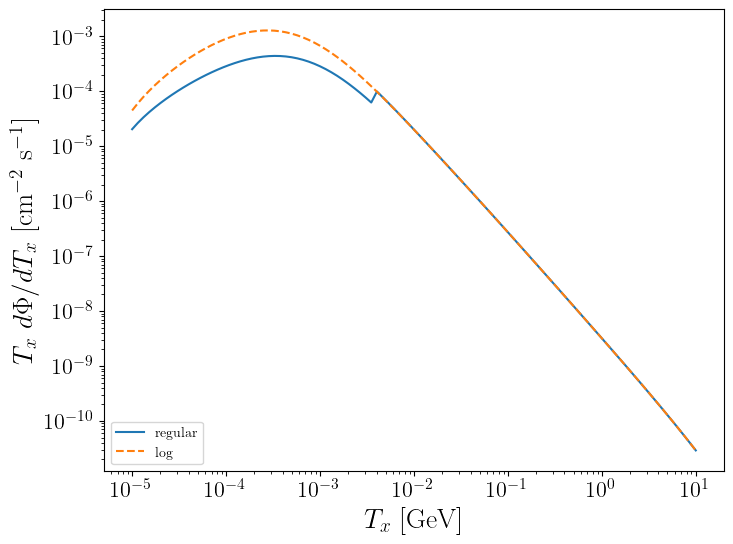

In [16]:
tt = np.logspace(-5, 1, 100)
gxLight = np.sqrt(0.001)
mx = 1e-3
mA = 1e-3
yy = [unitsCM2S * t * dphidTx2(t, mx, .0001, gxLight, .001) for t in tt]
yy_log = [unitsCM2S * t * dphidTx2_log(t, mx, .0001, gxLight, .001) for t in tt]
plt.figure(figsize=(8, 6))
plt.plot(tt, yy, label='regular')
plt.plot(tt, yy_log, '--', label='log')
plt.legend(loc="lower left")
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$T_x$ [GeV]', fontsize=20)
plt.ylabel('$T_x\,\, d\Phi/dT_x$ [cm$^{-2}$ s$^{-1}$]', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()